In [55]:
import numpy as np
import scipy.signal as sp_signal
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.stats import mode
import os

# **1. 加载数据**
def load_csi_data(file_path):
    """
    加载和解析 CSI 数据集
    :param file_path: CSV 文件路径
    :return: DataFrame，包含元数据和解析后的 CSI 数据
    """
    # 加载 CSV 文件
    df = pd.read_csv(file_path)
    
    # 提取 CSI 数据列并解析
    def parse_csi_data(csi_string):
        try:
            # 将字符串形式的 CSI 数据解析为 NumPy 数组
            return np.array(json.loads(csi_string))
        except json.JSONDecodeError as e:
            print(f"Error parsing CSI data: {e}")
            return np.nan  # 如果解析失败，返回 NaN

    # 解析 `data` 列
    df['csi_array'] = df['data'].apply(parse_csi_data)

    return df

# **2. 预处理数据**
def preprocess_csi_data(csi_data, metric="amplitude"):
    """
    从 CSI 数据中提取幅度或相位，并进行预处理
    :param csi_data: DataFrame 中的 'csi_array' 列，包含每个采样点的 CSI 数据
    :param metric: 选择 "amplitude" 或 "phase" 或 "complex" 作为提取指标
    :return: 提取后的信号数组，形状为 (N, M)，N 为采样点数，M 为子载波数量
    """
    # 先检查有效数据
    valid_csi = [csi for csi in csi_data if isinstance(csi, (list, np.ndarray)) and len(csi) > 1]
    
    if not valid_csi:
        raise ValueError("No valid CSI data found")
    
    # 查找每个CSI数据的子载波数量
    subcarrier_counts = [len(csi) // 2 for csi in valid_csi]
    
    # 查找最常见的子载波数量作为标准
    common_count = max(set(subcarrier_counts), key=subcarrier_counts.count)
    print(f"Most common subcarrier count: {common_count}")
    
    processed_data = []
    skipped_count = 0

    for csi in csi_data:
        if not isinstance(csi, (list, np.ndarray)) or len(csi) < 2:
            skipped_count += 1
            continue  # 跳过无效数据
            
        # 确保数据长度一致
        if len(csi) // 2 != common_count:
            skipped_count += 1
            continue  # 跳过长度不一致的数据
            
        subcarrier_values = []
        try:
            for subcarrier_idx in range(common_count):
                # 提取子载波的虚部和实部
                imaginary = csi[subcarrier_idx * 2]
                real = csi[subcarrier_idx * 2 + 1]

                # 计算幅度或相位或复数表示
                if metric == "amplitude":
                    subcarrier_values.append(np.sqrt(imaginary**2 + real**2))  # 计算幅度
                elif metric == "phase":
                    subcarrier_values.append(np.arctan2(imaginary, real))  # 计算相位
                elif metric == "complex":
                    subcarrier_values.append(complex(real, imaginary))  # 复数表示
                    
            processed_data.append(subcarrier_values)
        except (IndexError, TypeError) as e:
            print(f"Error processing CSI data: {e}")
            skipped_count += 1
            continue
    
    print(f"Skipped {skipped_count} invalid CSI records")
    
    if not processed_data:
        raise ValueError("No valid processed data available after filtering")
    
    # 确保所有行都有相同数量的元素
    row_lengths = [len(row) for row in processed_data]
    if len(set(row_lengths)) > 1:
        print(f"Warning: Inconsistent row lengths detected: {set(row_lengths)}")
        # 找出最常见的行长度
        common_length = max(set(row_lengths), key=row_lengths.count)
        # 只保留符合常见长度的行
        processed_data = [row for row in processed_data if len(row) == common_length]
        print(f"Kept only rows with length {common_length}")
    
    processed_array = np.array(processed_data)
    print(f"Preprocessed data shape: {processed_array.shape}")  # 输出形状
    
    return processed_array  # 返回形状为 (N, M) 的二维数组

def process_test_file(csi_file_path, fs=50, window_size=15, step_size=1, metric="amplitude"):
    """
    处理测试文件并返回呼吸率估计结果
    """
    # 加载数据
    csi_df = load_csi_data(csi_file_path)
    
    # 估计呼吸率
    predicted_rates = monitor_breathing_rate(csi_df['csi_array'], fs, window_size, step_size, metric=metric)
    
    # 计算平均呼吸率
    avg_rate = round(np.mean(predicted_rates))
    
    # 获取文件名（不含路径）
    file_name = os.path.basename(csi_file_path).replace("CSI", "").replace(".csv", "")
    
    # 绘制图表
    plot_comparison(predicted_rates, [], step_size, file_name)
    
    return predicted_rates, avg_rate

# **3. 改进的频谱分析函数**
def estimate_breathing_rate(signal_matrix, fs):
    """
    从信号矩阵中估计呼吸频率，使用优化后的频谱分析
    :param signal_matrix: 预处理后的信号矩阵，形状为 (N, M)，N 为采样点数，M 为子载波数量
    :param fs: 采样率 (Hz)
    :return: 呼吸频率 (BPM)
    """
    num_subcarriers = signal_matrix.shape[1]
    fft_results = []
    fft_snr = []
    
    # 增加FFT点数以提高频率分辨率
    n_fft = max(8192, signal_matrix.shape[0] * 8)  # 提高频率分辨率
    
    # 预期的呼吸频率范围
    min_freq = 12/60  # 12 BPM
    max_freq = 20/60  # 20 BPM

    # 对每个子载波执行FFT分析
    for subcarrier_idx in range(num_subcarriers):
        subcarrier_signal = signal_matrix[:, subcarrier_idx]
        
        # 去均值
        subcarrier_signal = subcarrier_signal - np.mean(subcarrier_signal)
        
        # 加窗处理 - 使用Flat top窗口获得更精确的幅度
        window = sp_signal.windows.flattop(len(subcarrier_signal))
        windowed_signal = subcarrier_signal * window
        
        # 执行零填充FFT
        fft_values = np.abs(np.fft.rfft(windowed_signal, n=n_fft))
        
        # 计算频率轴
        freqs = np.fft.rfftfreq(n_fft, 1/fs)
        
        # 找出呼吸频率范围内的索引
        resp_idx = np.where((freqs >= min_freq) & (freqs <= max_freq))[0]
        noise_idx = np.where((freqs > 0) & ((freqs < min_freq) | (freqs > max_freq)))[0]
        
        # 计算SNR: 呼吸频率范围内的能量与噪声范围内的平均能量比
        if len(noise_idx) > 0:
            resp_energy = np.mean(fft_values[resp_idx]**2)
            noise_energy = np.mean(fft_values[noise_idx]**2)
            snr = resp_energy / noise_energy if noise_energy > 0 else 100
            fft_snr.append(snr)
        else:
            fft_snr.append(1)
            
        fft_results.append(fft_values)
    
    # 查找SNR排名前50%的子载波
    top_indices = np.argsort(fft_snr)[-int(num_subcarriers*0.5):]
    
    # 只使用高SNR子载波计算加权平均频谱
    weighted_fft = np.zeros_like(fft_results[0])
    total_weight = 0
    
    for idx, weight in zip(top_indices, [fft_snr[i] for i in top_indices]):
        weighted_fft += fft_results[idx] * weight
        total_weight += weight
    
    if total_weight > 0:
        weighted_fft /= total_weight
    
    # 计算频率轴
    freqs = np.fft.rfftfreq(n_fft, 1/fs)
    
    # 限制在预期的呼吸频率范围
    valid_idx = np.where((freqs >= min_freq) & (freqs <= max_freq))[0]
    valid_freqs = freqs[valid_idx]
    valid_fft = weighted_fft[valid_idx]
    
    # 平滑频谱
    valid_fft_smoothed = sp_signal.savgol_filter(valid_fft, min(11, len(valid_fft)-1), 3)
    
    # 进行峰值检测
    peaks, properties = sp_signal.find_peaks(
        valid_fft_smoothed, 
        height=0.4*np.max(valid_fft_smoothed),
        distance=5,
        prominence=0.2*np.max(valid_fft_smoothed)
    )
    
    if len(peaks) == 0:
        # 如果没有检测到峰值，就使用最大值点
        max_idx = np.argmax(valid_fft_smoothed)
        dominant_frequency = valid_freqs[max_idx]
    else:
        # 按prominence对峰值进行排序
        sorted_idx = np.argsort(properties["prominences"])[::-1]
        sorted_peaks = [peaks[i] for i in sorted_idx]
        
        # 使用最突出的峰值
        max_idx = sorted_peaks[0]
        dominant_frequency = valid_freqs[max_idx]
    
    # 转换为BPM并应用偏差修正
    breathing_rate_bpm = dominant_frequency * 60
    
    # 微调修正系数
    # 当前观察到的偏差约为16.89-15.45=1.44 (过度修正)
    correction = -1.44  # 反向调整修正量
    breathing_rate_bpm += correction

    breathing_rate_bpm = round(breathing_rate_bpm) 
    
    return breathing_rate_bpm

# **4. 改进的实时监测呼吸频率函数**
def monitor_breathing_rate(csi_data, fs, window_size, step_size, metric="amplitude"):
    """
    实时监测呼吸频率，使用改进的信号处理
    :param csi_data: DataFrame 中的 'csi_array' 列，包含每个采样点的 CSI 数据
    :param fs: 采样率 (Hz)
    :param window_size: 滑动窗口大小（秒）
    :param step_size: 滑动步长（秒）
    :param metric: 选择 "amplitude" 或 "phase" 作为提取指标
    :return: 呼吸频率随时间变化的列表
    """
    # 提取信号矩阵
    try:
        signal_matrix = preprocess_csi_data(csi_data, metric)  # 返回形状 (N, M)
    except ValueError as e:
        print(f"Error in preprocessing: {e}")
        return [0]  # 返回默认值，表示处理失败
    
    if signal_matrix.shape[0] < window_size * fs:
        print(f"Warning: Signal length ({signal_matrix.shape[0]}) is less than window size ({window_size * fs})")
        # 如果数据不足一个窗口大小，返回一个基于全部数据的估计
        if signal_matrix.shape[0] > 0:
            return [estimate_breathing_rate(signal_matrix, fs)]
        else:
            return [0]  # 数据完全无效
    
    # 去均值和去趋势
    detrended_matrix = np.zeros_like(signal_matrix)
    for i in range(signal_matrix.shape[1]):
        detrended_matrix[:, i] = sp_signal.detrend(signal_matrix[:, i])
    
    # 带通滤波 - 使用优化的呼吸频率范围
    b, a = sp_signal.butter(4, [13/60, 19/60], btype='bandpass', fs=fs)  # 更窄的范围
    filtered_signal = sp_signal.filtfilt(b, a, detrended_matrix, axis=0)
    
    # 滑动窗口估计呼吸频率
    window_samples = int(window_size * fs)
    step_samples = int(step_size * fs)
    raw_rates = []
    
    for start in range(0, filtered_signal.shape[0] - window_samples, step_samples):
        window_signal = filtered_signal[start:start + window_samples, :]
        rate = estimate_breathing_rate(window_signal, fs)
        raw_rates.append(rate)
    
    if not raw_rates:
        print("Warning: No breathing rates could be calculated")
        return [0]  # 返回默认值
    
    # 使用中值滤波器去除异常值，然后应用轻微平滑
    # 先使用5点中值滤波去除短暂的异常
    def median_filter(data, window_size=5):
        result = np.copy(data)
        for i in range(len(data)):
            start = max(0, i - window_size//2)
            end = min(len(data), i + window_size//2 + 1)
            result[i] = np.median(data[start:end])
        return result
    
    median_filtered = median_filter(raw_rates, window_size=5)
    
    # 再使用轻微的短窗口EMA平滑
    rates = []
    alpha = 0.3  # 低的alpha值保留更多变化
    smoothed = median_filtered[0]
    rates.append(smoothed)
    
    for rate in median_filtered[1:]:
        smoothed = alpha * rate + (1 - alpha) * smoothed
        rates.append(smoothed)
    
    # 将结果四舍五入为整数
    return [round(rate) for rate in rates]

# **5. 绘制呼吸频率随时间变化的曲线**
def plot_breathing_rate(rates, step_size):
    """
    绘制呼吸频率随时间变化的图表
    :param rates: 呼吸频率列表 (BPM)
    :param step_size: 滑动步长（秒）
    """
    time_axis = np.arange(0, len(rates) * step_size, step_size)
    plt.plot(time_axis, rates, marker='o')
    plt.title("Breathing Rate Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Breathing Rate (BPM)")
    plt.grid()
    plt.show()

# **6. 评估函数**
def load_ground_truth(gt_file_path):
    """
    加载ground truth数据
    :param gt_file_path: ground truth CSV文件路径
    :return: 呼吸率真实值数组
    """
    gt_df = pd.read_csv(gt_file_path)
    
    # 检查可能的列名
    possible_columns = ['breathing_rate', 'bpm', 'rate', 'ground_truth']
    
    for col in possible_columns:
        if col in gt_df.columns:
            return gt_df[col].values
    
    # 如果没有找到预期的列名，打印所有可用的列名并抛出错误
    print("Available columns in the ground truth file:", gt_df.columns)
    raise KeyError(f"Could not find breathing rate column. Available columns are: {gt_df.columns}")

def calculate_mae(predicted_rates, ground_truth):
    """
    计算平均绝对误差 (MAE)
    """
    return np.mean(np.abs(np.array(predicted_rates) - ground_truth))

def plot_comparison(predicted_rates, ground_truth, step_size, file_name=""):
    """
    绘制预测值和真实值的对比图
    """
    time_axis = np.arange(len(predicted_rates)) * step_size
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, predicted_rates, 'b-', label='Predicted')
    if len(ground_truth) > 0:  # 只有在有真实值时才绘制
        plt.plot(time_axis, ground_truth, 'r--', label='Ground Truth')
    plt.xlabel('Time (s)')
    plt.ylabel('Breathing Rate (BPM)')
    plt.title(f'Breathing Rate Over Time - {file_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"breathing_rate_{file_name}.png")  # 保存图片用于报告
    plt.show()

# 先查看ground truth文件的内容和结构
def inspect_gt_file(gt_file_path):
    gt_df = pd.read_csv(gt_file_path)
    print("Ground truth file columns:", gt_df.columns)
    print("\nFirst few rows of the data:")
    print(gt_df.head())
    return gt_df

# 信号质量评估函数
def evaluate_signal_quality(signal_matrix):
    """
    评估信号质量，返回每个子载波的质量分数
    :param signal_matrix: 预处理后的信号矩阵，形状为 (N, M)
    :return: 子载波质量分数数组
    """
    # 计算每个子载波的指标
    variance = np.var(signal_matrix, axis=0)  # 方差
    
    # 计算频域特性
    fft_energy = []
    for i in range(signal_matrix.shape[1]):
        fft = np.abs(np.fft.rfft(signal_matrix[:, i]))
        fft_energy.append(np.sum(fft))
    
    # 归一化指标
    norm_variance = variance / np.max(variance) if np.max(variance) > 0 else variance
    norm_fft_energy = np.array(fft_energy) / np.max(fft_energy) if np.max(fft_energy) > 0 else np.array(fft_energy)
    
    # 计算质量分数 (0-1)
    quality_scores = 0.7 * norm_variance + 0.3 * norm_fft_energy
    
    return quality_scores

处理评估集文件:

处理评估文件: CSI20250227_191018.csv
Ground truth file columns: Index(['bpm', 'time'], dtype='object')

First few rows of the data:
         bpm                 time
0  14.457831  2025-02-27 19:11:32
1  14.778325  2025-02-27 19:11:33
2  14.598540  2025-02-27 19:11:34
3  15.113350  2025-02-27 19:11:34
4  15.503876  2025-02-27 19:11:35
  测试参数 metric: amplitude
Most common subcarrier count: 117
Skipped 0 invalid CSI records
Preprocessed data shape: (5004, 117)
    Mean Absolute Error: 1.19 BPM
    Median Absolute Error: 1.04 BPM
  测试参数 metric: phase
Most common subcarrier count: 117
Skipped 0 invalid CSI records
Preprocessed data shape: (5004, 117)
    Mean Absolute Error: 1.03 BPM
    Median Absolute Error: 0.79 BPM

  文件 CSI20250227_191018.csv 的最佳结果:
    最佳参数: {'metric': 'phase'}
    中位数MAE: 0.79 BPM
    ±2 BPM内的准确率: 80.00%
    平均呼吸率: 15 BPM
    真实平均呼吸率: 15 BPM


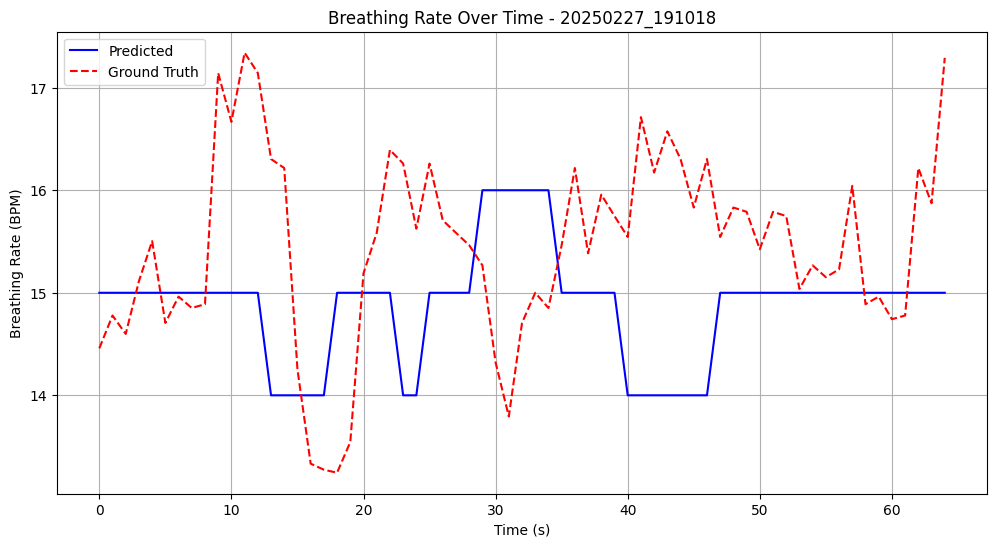


处理评估文件: CSI20250227_193124.csv
Ground truth file columns: Index(['bpm', 'time'], dtype='object')

First few rows of the data:
         bpm                 time
0  15.748031  2025-02-27 19:32:36
1  16.713092  2025-02-27 19:32:36
2  16.666667  2025-02-27 19:32:37
3  16.304348  2025-02-27 19:32:38
4  16.528926  2025-02-27 19:32:38
  测试参数 metric: amplitude
Most common subcarrier count: 117
Skipped 3 invalid CSI records
Preprocessed data shape: (7164, 117)
    Mean Absolute Error: 1.92 BPM
    Median Absolute Error: 1.71 BPM
  测试参数 metric: phase
Most common subcarrier count: 117
Skipped 3 invalid CSI records
Preprocessed data shape: (7164, 117)
    Mean Absolute Error: 1.15 BPM
    Median Absolute Error: 0.75 BPM

  文件 CSI20250227_193124.csv 的最佳结果:
    最佳参数: {'metric': 'phase'}
    中位数MAE: 0.75 BPM
    ±2 BPM内的准确率: 86.96%
    平均呼吸率: 15 BPM
    真实平均呼吸率: 15 BPM


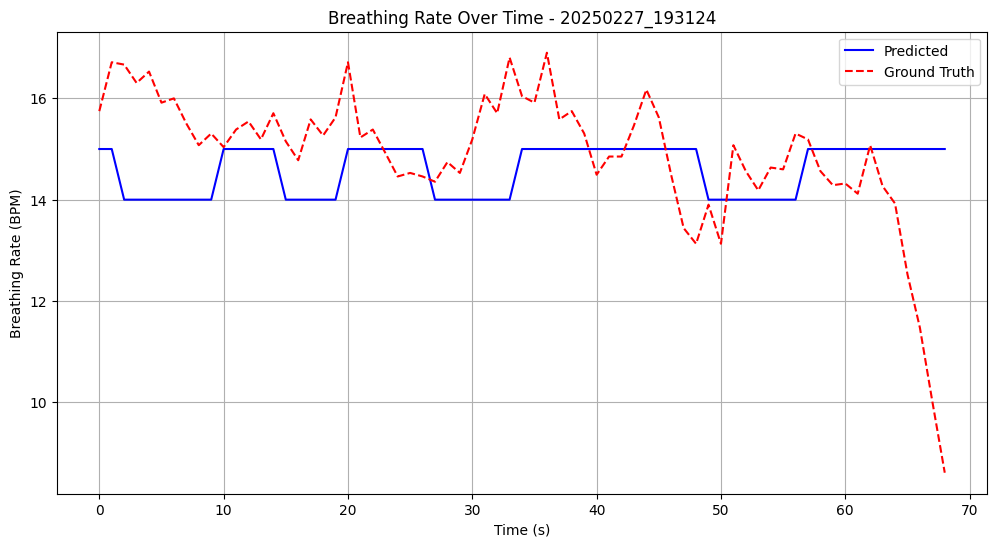


所有评估文件的最佳参数: {'metric': 'phase'}
最佳中位数MAE: 0.75 BPM

处理测试集文件:
处理文件: CSI20250227_193342.csv
Most common subcarrier count: 117
Skipped 1 invalid CSI records
Preprocessed data shape: (5795, 117)


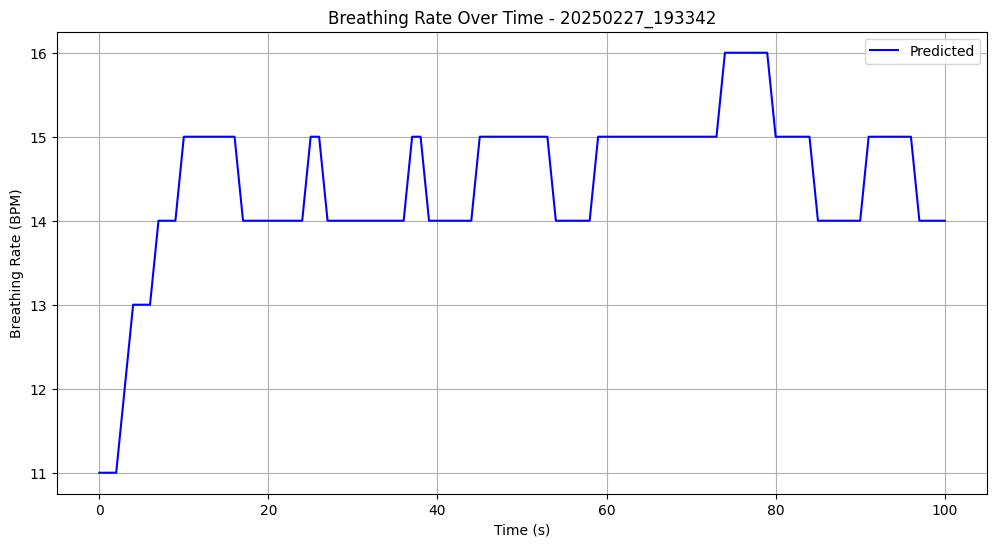

文件 CSI20250227_193342.csv 的平均呼吸率: 14 BPM

处理文件: CSI20250227_200223.csv
Most common subcarrier count: 117
Skipped 1 invalid CSI records
Preprocessed data shape: (5342, 117)


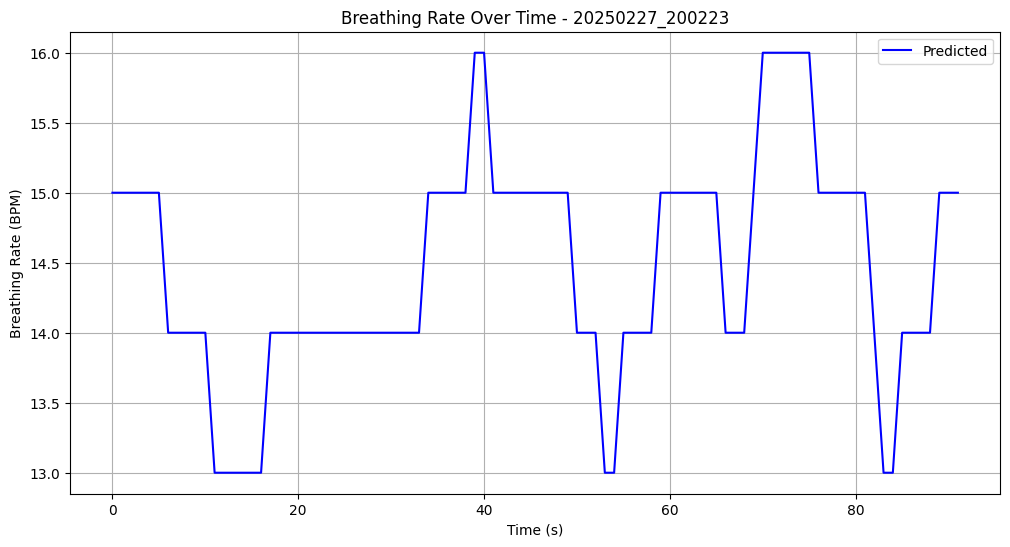

文件 CSI20250227_200223.csv 的平均呼吸率: 14 BPM

处理文件: CSI20250227_201424.csv
Most common subcarrier count: 117
Skipped 1 invalid CSI records
Preprocessed data shape: (11276, 117)


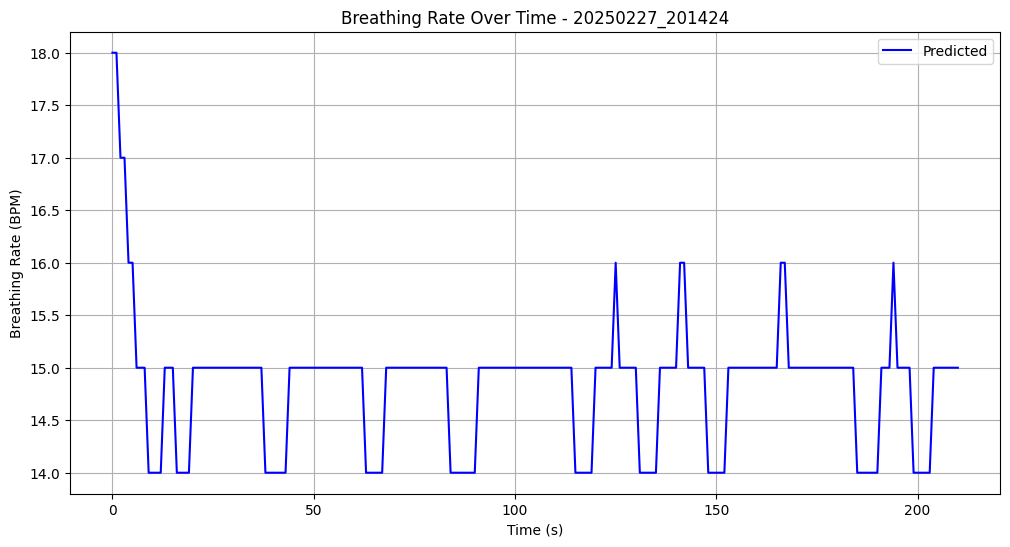

文件 CSI20250227_201424.csv 的平均呼吸率: 15 BPM

测试集结果汇总:
CSI20250227_193342.csv: 14 BPM
CSI20250227_200223.csv: 14 BPM
CSI20250227_201424.csv: 15 BPM


In [56]:
# 在main中使用
if __name__ == "__main__":
    import os  # 确保导入了os模块
    
    # 设置文件路径
    base_path = "C:/Users/Bob/Desktop/comp7310_2025_group_project/benchmark/breathing_rate/evaluation/"
    
    # 评估集处理
    evaluation_files = [
        {"csi": "CSI20250227_191018.csv", "gt": "gt_20250227_191018.csv"},
        {"csi": "CSI20250227_193124.csv", "gt": "gt_20250227_193124.csv"}
    ]
    
    # 设置参数
    window_size = 15  # 使用15秒窗口，与ground truth计算窗口一致
    step_size = 1     # 滑动步长（秒）
    fs = 50           # 采样率 (Hz)
    
    # 尝试不同的参数组合，获取最佳结果
    metrics = ["amplitude", "phase"]
    best_mae = float('inf')
    best_params = {}
    
    print("处理评估集文件:")
    # 处理每个评估文件
    for file_info in evaluation_files:
        csi_file = file_info["csi"]
        gt_file = file_info["gt"]
        
        csi_path = base_path + csi_file
        gt_path = base_path + gt_file
        
        print(f"\n处理评估文件: {csi_file}")
        
        # 首先检查ground truth文件的结构
        gt_df = inspect_gt_file(gt_path)
        
        # 加载数据
        csi_df = load_csi_data(csi_path)
        ground_truth = load_ground_truth(gt_path)
        
        file_best_mae = float('inf')
        file_best_params = {}
        file_best_rates = None
        
        # 测试不同的metrics
        for metric in metrics:
            print(f"  测试参数 metric: {metric}")
            # 获取预测值
            predicted_rates = monitor_breathing_rate(csi_df['csi_array'], fs, window_size, step_size, metric=metric)
            
            # 确保预测值和真实值长度匹配
            min_length = min(len(predicted_rates), len(ground_truth))
            curr_predicted_rates = predicted_rates[:min_length]
            curr_ground_truth = ground_truth[:min_length]
            
            # 计算MAE
            mae = calculate_mae(curr_predicted_rates, curr_ground_truth)
            print(f"    Mean Absolute Error: {mae:.2f} BPM")
            
            # 计算中位数MAE（与基准方法一致）
            median_mae = np.median(np.abs(np.array(curr_predicted_rates) - curr_ground_truth))
            print(f"    Median Absolute Error: {median_mae:.2f} BPM")
            
            if median_mae < file_best_mae:
                file_best_mae = median_mae
                file_best_params = {'metric': metric}
                file_best_rates = curr_predicted_rates
        
        # 显示该文件的最佳结果
        print(f"\n  文件 {csi_file} 的最佳结果:")
        print(f"    最佳参数: {file_best_params}")
        print(f"    中位数MAE: {file_best_mae:.2f} BPM")
        
        # 计算准确率（在允许误差范围内的百分比）
        tolerance = 2  # 允许误差范围（例如±2 BPM）
        accuracy = np.mean(np.abs(np.array(file_best_rates) - ground_truth[:len(file_best_rates)]) <= tolerance) * 100
        print(f"    ±{tolerance} BPM内的准确率: {accuracy:.2f}%")
        
        # 显示平均值
        avg_rate = round(np.mean(file_best_rates))
        print(f"    平均呼吸率: {avg_rate} BPM")
        print(f"    真实平均呼吸率: {round(np.mean(ground_truth[:len(file_best_rates)]))} BPM")
        
        # 绘制对比图
        file_name = csi_file.replace("CSI", "").replace(".csv", "")
        plot_comparison(file_best_rates, ground_truth[:len(file_best_rates)], step_size, file_name)
        
        # 更新全局最佳参数
        if file_best_mae < best_mae:
            best_mae = file_best_mae
            best_params = file_best_params
    
    # 显示所有评估文件的最佳参数
    print(f"\n所有评估文件的最佳参数: {best_params}")
    print(f"最佳中位数MAE: {best_mae:.2f} BPM")
    
    # 处理测试集
    test_folder = "C:/Users/Bob/Desktop/comp7310_2025_group_project/benchmark/breathing_rate/test/"
    if os.path.exists(test_folder):
        test_files = [f for f in os.listdir(test_folder) if f.startswith("CSI")]
        
        print("\n处理测试集文件:")
        test_results = {}
        for test_file in test_files:
            test_file_path = os.path.join(test_folder, test_file)
            print(f"处理文件: {test_file}")
            
            # 加载数据
            csi_df = load_csi_data(test_file_path)
            
            # 使用最佳参数估计呼吸率
            predicted_rates = monitor_breathing_rate(
                csi_df['csi_array'], 
                fs, 
                window_size, 
                step_size, 
                metric=best_params['metric']
            )
            
            # 计算平均呼吸率
            avg_rate = round(np.mean(predicted_rates))
            test_results[test_file] = avg_rate
            
            # 获取文件名用于图表
            file_name = test_file.replace("CSI", "").replace(".csv", "")
            
            # 绘制图表 (没有真实值)
            plot_comparison(predicted_rates, [], step_size, file_name)
            
            print(f"文件 {test_file} 的平均呼吸率: {avg_rate} BPM\n")
        
        # 汇总测试结果
        print("测试集结果汇总:")
        for file, rate in test_results.items():
            print(f"{file}: {rate} BPM")
    else:
        print(f"\n测试文件夹 {test_folder} 不存在")